In [1]:
%matplotlib inline


# Classification of text documents using sparse features


This is an example showing how scikit-learn can be used to classify documents
by topics using a bag-of-words approach. This example uses a scipy.sparse
matrix to store the features and demonstrates various classifiers that can
efficiently handle sparse matrices.

The dataset used in this example is the 20 newsgroups dataset. 
The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents.
It will be automatically downloaded, then cached. 

The bar plot indicates the accuracy, training time (normalized) and test time
(normalized) of each classifier.




In [4]:
from __future__ import print_function

import logging
import numpy as np
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from sklearn import metrics


print("Loading 20 newsgroups dataset for categories:")

data_train = fetch_20newsgroups(subset='train', categories=None,
                                shuffle=True, random_state=42)

data_test = fetch_20newsgroups(subset='test', categories=None,
                               shuffle=True, random_state=42)
print('data loaded')


target_names = data_train.target_names

categories = data_train.target_names


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(categories))
print("categories values: ",categories)
print()

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target



Loading 20 newsgroups dataset for categories:
data loaded
11314 documents - 22.055MB (training set)
7532 documents - 13.801MB (test set)
20 categories
categories values:  ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']



array([7, 4, 4, ..., 3, 1, 8])

<h3>Text feature extraction</h3> 

In [10]:
from time import time

t0 = time()
print("Extracting features from the training data using a sparse vectorizer")
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)

duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

Extracting features from the training data using a sparse vectorizer
done in 5.885906s at 3.747MB/s
n_samples: 11314, n_features: 129791

Extracting features from the test data using the same vectorizer
done in 2.190805s at 6.299MB/s
n_samples: 7532, n_features: 129791



<h3> Train classifier to predict category per instance </h3>

SVM
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


train time: 0.918s
test time:  0.090s
accuracy:   0.859

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=None, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


train time: 0.854s
test time:  0.125s
accuracy:   0.807

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
train time: 0.546s
test time:  0.101s
accuracy:   0.820



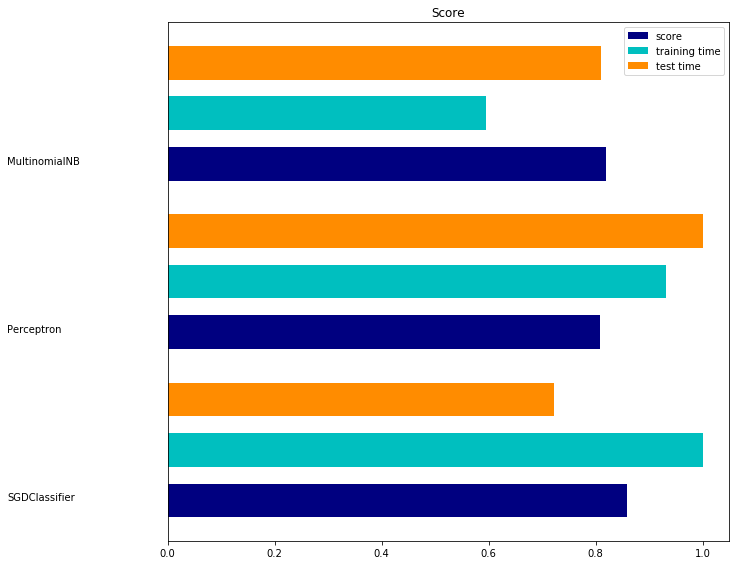

In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (SGDClassifier(),"SVM"),
        (Perceptron(), "Perceptron"),
        (MultinomialNB(),"Naive Bayes")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

<h3> Optimize the NB Classifier </h3>
<a href="http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html">documentation</a>


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

nb_clf = Pipeline([('vect', TfidfVectorizer()),('clf', MultinomialNB())])
parameters =  {'vect__max_df': (0.3,0.5),'clf__alpha': (0.01,1.0)}
gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=1)
gs_clf = gs_clf.fit(data_train.data,data_train.target)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)